# Pr.7 Прогнозирование оттока клиентов банка

<div style="border:solid blue 2px; padding: 20px"> <h3 style="color: blue; margin-bottom:20px">Внимание</h3> 
    Расчет нескольких ячеек (подбор параметров в цикле) занимает от 2 до 4 минут каждая.
</div>

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_curve
#from sklearn.metrics import precision_recall_curve

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 

#from sklearn.metrics import accuracy_score
#from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)  # игнорирование будущих предупреждений
warnings.filterwarnings("ignore")  - игнорирование всех предупреждений

In [2]:
path='https://code.s3.yandex.net/datasets/'
file_name='Churn.csv'
df = pd.read_csv(path+file_name) #,sep='\t')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [5]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

Сменим регистр в названиях столбцов и переименуем некоторые из них для бОльшей "читабельности".

In [6]:
df.columns = df.columns.str.lower()
df = df.rename(columns = {'rownumber' : 'row_number',
                            'customerid' : 'customer_id',
                            'creditscore' : 'cred_score',
                            'numofproducts' : 'prod_number',
                            'hascrcard' : 'has_cr_card',
                            'isactivemember' : 'is_active',
                            'estimatedsalary' : 'salary',
                            'geography':'geogr',
                            'gender':'gend'
                           })
df.columns

Index(['row_number', 'customer_id', 'surname', 'cred_score', 'geogr', 'gend',
       'age', 'tenure', 'balance', 'prod_number', 'has_cr_card', 'is_active',
       'salary', 'exited'],
      dtype='object')

Изучим описательные статистики для численных признаков:

In [7]:
df.describe().round(1)

,row_number,customer_id,cred_score,age,tenure,balance,prod_number,has_cr_card,is_active,salary,exited
count,10000.0,10000.0,10000.0,10000.0,9091.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
mean,5000.5,15690940.6,650.5,38.9,5.0,76485.9,1.5,0.7,0.5,100090.2,0.2
std,2886.9,71936.2,96.7,10.5,2.9,62397.4,0.6,0.5,0.5,57510.5,0.4
min,1.0,15565701.0,350.0,18.0,0.0,0.0,1.0,0.0,0.0,11.6,0.0
25%,2500.8,15628528.2,584.0,32.0,2.0,0.0,1.0,0.0,0.0,51002.1,0.0
50%,5000.5,15690738.0,652.0,37.0,5.0,97198.5,1.0,1.0,1.0,100193.9,0.0
75%,7500.2,15753233.8,718.0,44.0,7.0,127644.2,2.0,1.0,1.0,149388.2,0.0
max,10000.0,15815690.0,850.0,92.0,10.0,250898.1,4.0,1.0,1.0,199992.5,1.0


Это сразу позволяет проанализировать многое.<br>
- Колонки "row_number", "credit_score", "age", "tenure" и "salary" имеют  несмещенное распределение (их медианы практически равны их средним);
- Имеем сильный дисбаланс классов: ушедших клиентов - 20%, оставшихся - 80%;
- Колонка "row_number" полностью дублирует индексы датафрейма;
- Средний кредитный рейтинг - 650, средний возраст - 39 лет, среднее число продуктов - 1.5, средняя зарплата - 100090, в среднем у клиента 5 объектов недвижимости, 70% клиентов имеют кредитные карты, активных и пассивных клиентов поровну.

Чтобы объекты с бОльшим номером ряда не влияли на модель в бОльшей степени, удалим колонку "row_number".

In [8]:
df = df.drop('row_number', axis = 1)

In [9]:
df.head(1)

,customer_id,surname,cred_score,geogr,gend,age,tenure,balance,prod_number,has_cr_card,is_active,salary,exited
0,15634602,Hargrave,619,France,Female,42,2.0,0.0,1,1,1,101348.88,1


In [10]:
df['tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: tenure, dtype: int64

In [11]:
df['tenure'].value_counts().sum()

9091

In [12]:
df['tenure'].isna().sum()

909

Заполним пропуски в количестве недвижимости медианой и заодно изменим тип на целочисленный:

In [13]:
df['tenure'] = df['tenure'].fillna(df['tenure'].median()).astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  10000 non-null  int64  
 1   surname      10000 non-null  object 
 2   cred_score   10000 non-null  int64  
 3   geogr        10000 non-null  object 
 4   gend         10000 non-null  object 
 5   age          10000 non-null  int64  
 6   tenure       10000 non-null  int32  
 7   balance      10000 non-null  float64
 8   prod_number  10000 non-null  int64  
 9   has_cr_card  10000 non-null  int64  
 10  is_active    10000 non-null  int64  
 11  salary       10000 non-null  float64
 12  exited       10000 non-null  int64  
dtypes: float64(2), int32(1), int64(7), object(3)
memory usage: 976.7+ KB


In [14]:
df.duplicated().sum()

0

Полных дубликатов нет.  Теперь проанализируем качественные признаки.

In [15]:
df['gend'].value_counts()

Male      5457
Female    4543
Name: gend, dtype: int64

In [16]:
df['geogr'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: geogr, dtype: int64

Соотношение мужчин и женщин - 55% / 45%. География представлена 3мя странами.<br>

Фамилия не является признаком, от которого зависит отток, так же как и идентификатор клиента: эти колонки мы удалим. <br>
Колонки с полом и географией преобразуем техникой прямого кодирования OHE.


In [17]:
df = df.drop('surname', axis = 1)
df = df.drop('customer_id', axis = 1)

In [18]:
df = pd.get_dummies(df, drop_first=True)
df.head(2)

,cred_score,age,tenure,balance,prod_number,has_cr_card,is_active,salary,exited,geogr_Germany,geogr_Spain,gend_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0


In [19]:
df.columns = df.columns.str.lower()
display(df.head(1))
print(df.shape)

,cred_score,age,tenure,balance,prod_number,has_cr_card,is_active,salary,exited,geogr_germany,geogr_spain,gend_male
0,619,42,2,0.0,1,1,1,101348.88,1,0,0,0


(10000, 12)


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   cred_score     10000 non-null  int64  
 1   age            10000 non-null  int64  
 2   tenure         10000 non-null  int32  
 3   balance        10000 non-null  float64
 4   prod_number    10000 non-null  int64  
 5   has_cr_card    10000 non-null  int64  
 6   is_active      10000 non-null  int64  
 7   salary         10000 non-null  float64
 8   exited         10000 non-null  int64  
 9   geogr_germany  10000 non-null  uint8  
 10  geogr_spain    10000 non-null  uint8  
 11  gend_male      10000 non-null  uint8  
dtypes: float64(2), int32(1), int64(6), uint8(3)
memory usage: 693.5 KB


# 2. Исследование задачи

Выделим признаки и целевую переменную.

In [21]:
target = df['exited']
features = df.drop('exited', axis=1)

Поделим наш датасет на обучающую, валидационную и тестовую выборки в соотношении 60% / 20% / 20%. <br>

Зададим для удобства изменения некоторые гиперпараметры.

In [22]:
RS = 12345 # random_state

In [23]:
#выделяем 20% из всего набора на тестовую выборку  
features_train_valid, features_test, target_train_valid, target_test = train_test_split(
    features, target, test_size=0.2, random_state = RS, stratify = target)   # будем использовать разделение 
                                                                       #на стратифицированные выборки по таргету
#из оставшихся 80%  отделяем четверть на валидационную выборку 
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_valid, target_train_valid, test_size=0.25, random_state = RS, stratify = target_train_valid)

Проверим размеры получившихся выборок:

In [24]:
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(6000, 11)
(2000, 11)
(2000, 11)


In [25]:
print(target_train.shape)
print(target_valid.shape)
print(target_test.shape)

(6000,)
(2000,)
(2000,)


Соотношение выборок верное.

Проведем стандартизацию признаков. 

Отделим изначально-численные признаки в отдельный массив и стандартизируем их. Несмотря на то, что после обработки категориальных признаков все признаки стали численным, отделить их все равно нужно, потому что три новых признака ('geogr_germany',  'geogr_spain' и 'gend_male') имеют тип "uint8", то есть не могут быть отрицательными, а только положительными. А стандартизация приводит к стандартному нормальному рапределению, то есть стандартизирует из вокруг нуля (и больше нуля, и меньше). 

In [26]:
numeric = ['cred_score', 'age', 'tenure', 'balance', 'prod_number', 'has_cr_card', 'is_active', 'salary']

In [46]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

C:\Users\EI\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\EI\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\EI\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

Мы имеем дело с задачей классификации. 

Построим модель логистической регрессии. Посчитаем на ней метрики F1 и AUC-ROC.

In [28]:
model_lr = LogisticRegression(random_state = RS, solver='liblinear')
model_lr.fit(features_train, target_train)
predicted_valid = model_lr.predict(features_valid)
print(f'F1 для логистической регрессии : {f1_score( target_valid, predicted_valid )}')

# для построения AUC-ROC посчитаем вероятности попадания целевой переменной в тот или иной класс
probabilities_valid = model_lr.predict_proba(features_valid)

# веротности попадания в класс "1":
probabilities_one_valid = probabilities_valid[:, 1] 

auc_roc = roc_auc_score(target_valid , probabilities_one_valid)
print(f'AUC-ROC для логистической регрессии : {auc_roc}')

F1 для логистической регрессии : 0.3214953271028037
AUC-ROC для логистической регрессии : 0.7875502621265333


**F1 для логистической регрессии равно 0.321. 
AUC-ROC для логистической регрессии равно 0.787**

Визуализируем метрику AUC_ROC: построим roc-кривую и оценим визуально площадь под ней.

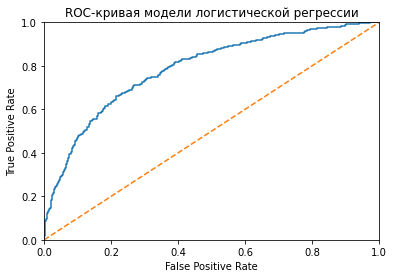

In [29]:
fpr, tpr, thresholds =  roc_curve(target_valid, probabilities_one_valid) 

# построим график roc-кривой для модели логистической регрессии
plt.figure() 
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая модели логистической регрессии')
# ROC-кривая случайной модели 
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

По умолчанию порог логистической регрессии равен 0.5. Попробуем его поменять.

In [30]:
best_lr_result = 0
best_threshold = 0
for threshold in np.arange(0, 0.6, 0.02):
    predicted_valid = probabilities_one_valid > threshold 
    precision = precision_score(target_valid, predicted_valid )
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)
    auc_roc = roc_auc_score(target_valid , probabilities_one_valid)
    if f1 > best_lr_result:
        best_lr_result = f1
        best_threshold = threshold
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.3f}, AUC_ROC = {:.3f}".format(
        threshold, precision, recall, f1, auc_roc))
print()
print(f'Лучшее значение F1 = {best_lr_result} при пороге = {best_threshold}')

Порог = 0.00 | Точность = 0.203, Полнота = 1.000, F1 = 0.338, AUC_ROC = 0.788
Порог = 0.02 | Точность = 0.204, Полнота = 1.000, F1 = 0.339, AUC_ROC = 0.788
Порог = 0.04 | Точность = 0.213, Полнота = 0.993, F1 = 0.351, AUC_ROC = 0.788
Порог = 0.06 | Точность = 0.230, Полнота = 0.975, F1 = 0.372, AUC_ROC = 0.788
Порог = 0.08 | Точность = 0.251, Полнота = 0.951, F1 = 0.397, AUC_ROC = 0.788
Порог = 0.10 | Точность = 0.266, Полнота = 0.919, F1 = 0.413, AUC_ROC = 0.788
Порог = 0.12 | Точность = 0.288, Полнота = 0.897, F1 = 0.436, AUC_ROC = 0.788
Порог = 0.14 | Точность = 0.311, Полнота = 0.860, F1 = 0.456, AUC_ROC = 0.788
Порог = 0.16 | Точность = 0.334, Полнота = 0.833, F1 = 0.477, AUC_ROC = 0.788
Порог = 0.18 | Точность = 0.357, Полнота = 0.784, F1 = 0.490, AUC_ROC = 0.788
Порог = 0.20 | Точность = 0.382, Полнота = 0.742, F1 = 0.504, AUC_ROC = 0.788
Порог = 0.22 | Точность = 0.404, Полнота = 0.690, F1 = 0.510, AUC_ROC = 0.788
Порог = 0.24 | Точность = 0.432, Полнота = 0.661, F1 = 0.523, AU

Получили, что ***для логистической регрессии наилучшее значение F1-меры*** (среднего гармонического полноты и точности)  достигается при снижении порога сильно вниз: ***F1 = 0.526 при пороге = 0.26***. 

Построим модель дерева решений. Подберем лучшую модель решающего дерева, перебирая гиперпараметр максимальной глубины.

In [31]:
best_tree_model = None
best_tree_result = 0
best_tree_depth = 0
best_tree_auc_roc = 0
best_tree_auc_depth = 0

for depth in range(1, 16):
    model_tree = DecisionTreeClassifier(random_state = RS, max_depth = depth)
    model_tree.fit(features_train, target_train)
    predicted_valid = model_tree.predict(features_valid)
    result = f1_score( target_valid, predicted_valid )
    probabilities_valid = model_tree.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    print("Глубина дерева = {} | F1 = {:.4f}, AUC-ROC = {:.4f}".format( depth, result, auc_roc ))
    if result > best_tree_result:
        best_tree_model = model_tree
        best_tree_result = result
        best_tree_depth = depth
    if auc_roc > best_tree_auc_roc:
        best_tree_auc_roc = auc_roc
        best_tree_auc_depth = depth

print("\nF1 лучшей модели дерева на валид. выборке: {:.3f} , лучшая макс. глубина: {}".format(
                                                                        best_tree_result, best_tree_depth))
print("\nAUC-ROC лучшей модели дерева на валид. выборке: {:.3f} , лучшая макс. глубина: {}".format(
                                                                    best_tree_auc_roc, best_tree_auc_depth))

Глубина дерева = 1 | F1 = 0.0000, AUC-ROC = 0.7020
Глубина дерева = 2 | F1 = 0.5148, AUC-ROC = 0.7398
Глубина дерева = 3 | F1 = 0.3750, AUC-ROC = 0.8042
Глубина дерева = 4 | F1 = 0.5169, AUC-ROC = 0.8272
Глубина дерева = 5 | F1 = 0.4632, AUC-ROC = 0.8351
Глубина дерева = 6 | F1 = 0.5382, AUC-ROC = 0.8285
Глубина дерева = 7 | F1 = 0.5505, AUC-ROC = 0.8311
Глубина дерева = 8 | F1 = 0.5817, AUC-ROC = 0.8097
Глубина дерева = 9 | F1 = 0.5770, AUC-ROC = 0.7983
Глубина дерева = 10 | F1 = 0.5330, AUC-ROC = 0.7789
Глубина дерева = 11 | F1 = 0.5591, AUC-ROC = 0.7608
Глубина дерева = 12 | F1 = 0.5354, AUC-ROC = 0.7417
Глубина дерева = 13 | F1 = 0.5104, AUC-ROC = 0.7289
Глубина дерева = 14 | F1 = 0.5171, AUC-ROC = 0.7064
Глубина дерева = 15 | F1 = 0.5118, AUC-ROC = 0.7006

F1 лучшей модели дерева на валид. выборке: 0.582 , лучшая макс. глубина: 8

AUC-ROC лучшей модели дерева на валид. выборке: 0.835 , лучшая макс. глубина: 5


***F1 лучшей модели дерева на валид. выборке: 0.582 , лучшая макс. глубина: 8.***

AUC-ROC лучшей модели дерева на валид. выборке: 0.835 , лучшая макс. глубина: 5

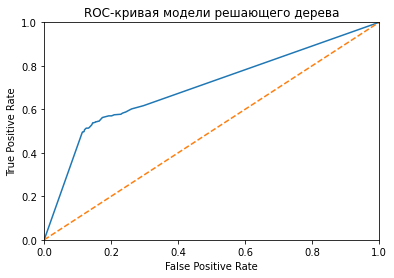

In [32]:
fpr, tpr, thresholds =  roc_curve(target_valid, probabilities_one_valid) 

# построим график roc-кривой для модели решающего дерева
plt.figure() 
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая модели решающего дерева')
# ROC-кривая случайной модели 
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

Построим модель случайного леса. Поищем лучший лес, изменяя количество деверьев и их максимальную глубину.

In [33]:
%%time

best_rf_result = 0        # лучший результат по основной метрике (F1)
best_rf_model = None      # лучшие модель, количество деревьев и глубина при этом
best_est = 0           
best_rf_depth = 0

best_rf_auc_roc = 0      # лучший результат по AUC-ROC
best_rf_auc_depth = 0    # лучшие глубина, количество деревьев  при этом
best_auc_est = 0

for est in range(10, 160, 10):
    for depth in range (1, 21):
        model_rf = RandomForestClassifier(random_state = RS, n_estimators = est, max_depth = depth)
        model_rf.fit(features_train, target_train) 
        predicted_valid = model_rf.predict(features_valid)
        result = f1_score( target_valid, predicted_valid )                   #F1
        probabilities_valid = model_rf.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]                  #AUC_ROC
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
        #print("Деревьев = {} | Глубина = {} | F1 = {:.4f}, AUC-ROC = {:.4f}".format( est, depth, result, auc_roc ))
        if result > best_rf_result:
            best_rf_model = model_rf
            best_rf_result = result
            best_rf_depth = depth
            best_est = est
        if auc_roc > best_rf_auc_roc:
            best_rf_auc_roc = auc_roc
            best_rf_auc_depth = depth
            best_auc_est = est
            
print("\nF1 лучшей модели случ. леса на валид. выборке: {:.3f} , лучшая макс. глубина: {}, кол-во деревьев: {}".format(
                                                         best_rf_result, best_rf_depth, best_est))
print("\nAUC-ROC лучшей модели случ. леса на валид. выборке: {:.3f} , лучшая макс. глубина: {}, кол-во деревьев: {}".format(
                                                  best_rf_auc_roc, best_rf_auc_depth, best_auc_est))
                                                  


F1 лучшей модели случ. леса на валид. выборке: 0.580 , лучшая макс. глубина: 19, кол-во деревьев: 100

AUC-ROC лучшей модели случ. леса на валид. выборке: 0.874 , лучшая макс. глубина: 7, кол-во деревьев: 150
Wall time: 4min 24s


**F1 лучшей модели дерева на валид. выборке: 0.580 , лучшая макс. глубина: 19, кол-во деревьев: 100**

**AUC-ROC лучшей модели дерева на валид. выборке: 0.874, лучшая макс. глубина: 7, кол-во деревьев: 150**

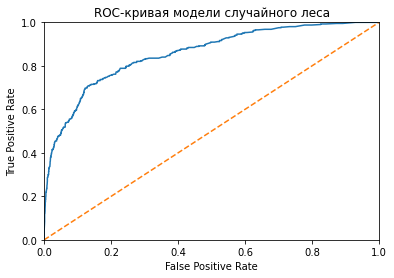

In [34]:
fpr, tpr, thresholds =  roc_curve(target_valid, probabilities_one_valid) 

# построим график roc-кривой для модели случайного леса
plt.figure() 
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая модели случайного леса')
# ROC-кривая случайной модели 
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

Посчитав F1-меру и AUC_ROC для моделей логистической регрессии, дерева и случайного леса **при несбалансированных классах, лучший результат по метрике F1 получили на модели решающего дерева (0.582), а по метрике AUC-ROC лучший результат - на мдели случайного леса (0.874)**.

0    0.7963
1    0.2037
Name: exited, dtype: float64


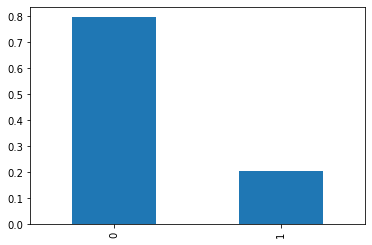

In [35]:
class_frequency = target.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar');

Как мы заметили ранее, мы имеем дело с несбалансированными классами целевой переменной: нулей в 4 раза больше, чем единиц. Посмотрим, что нам даст приведение классов к балансу.

# 3. Борьба с дисбалансом

## 3.1. Взвешивание классов

Используем взвешивание классов с помощью параметра class_weight, который есть у всех трех наших типов моделей.

In [36]:
model_lr_bal = LogisticRegression(random_state = RS, solver='liblinear', class_weight='balanced')
model_lr_bal.fit(features_train, target_train)
predicted_valid = model_lr_bal.predict(features_valid)
print(f'F1 для логистической регрессии при балансе классов: {f1_score( target_valid, predicted_valid )}')

probabilities_valid = model_lr_bal.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid , probabilities_one_valid)
print(f'AUC-ROC для логистической регрессии при балансе классов: {auc_roc}')

F1 для логистической регрессии при балансе классов: 0.5108601216333623
AUC-ROC для логистической регрессии при балансе классов: 0.7917624866777409


F1 для логистической регрессии **при балансе классов равно  0.511  против 0.321** без баланса классов. **Это увеличение метрики на целых 60%!** <br>
AUC-ROC для логистической регрессии при балансе классов  0.792 против 0.787. Баланс классов для AUC-ROC так же дал увеличение метрики, но менее, чем на 1%. 

Также попробуем подвигать порог: сейчас классы взвешены, поэтому порог не должен сильно отклоняться от 0.5. Поэтому перебор будем делать в пределах от 0.3 до 0.7.

In [37]:
best_lr_result = 0
best_threshold = 0
for threshold in np.arange(0.3, 0.7, 0.02):
    predicted_valid = probabilities_one_valid > threshold 
    precision = precision_score(target_valid, predicted_valid )
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)
    auc_roc = roc_auc_score(target_valid , probabilities_one_valid)
    if f1 > best_lr_result:
        best_lr_result = f1
        best_threshold = threshold
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.3f}, AUC_ROC = {:.3f}".format(
        threshold, precision, recall, f1, auc_roc))
print()
print(f'Лучшее значение F1 = {best_lr_result} при пороге = {best_threshold}')

Порог = 0.30 | Точность = 0.268, Полнота = 0.929, F1 = 0.416, AUC_ROC = 0.792
Порог = 0.32 | Точность = 0.278, Полнота = 0.921, F1 = 0.428, AUC_ROC = 0.792
Порог = 0.34 | Точность = 0.290, Полнота = 0.914, F1 = 0.440, AUC_ROC = 0.792
Порог = 0.36 | Точность = 0.298, Полнота = 0.887, F1 = 0.446, AUC_ROC = 0.792
Порог = 0.38 | Точность = 0.305, Полнота = 0.860, F1 = 0.450, AUC_ROC = 0.792
Порог = 0.40 | Точность = 0.322, Полнота = 0.853, F1 = 0.468, AUC_ROC = 0.792
Порог = 0.42 | Точность = 0.337, Полнота = 0.838, F1 = 0.481, AUC_ROC = 0.792
Порог = 0.44 | Точность = 0.351, Полнота = 0.811, F1 = 0.490, AUC_ROC = 0.792
Порог = 0.46 | Точность = 0.368, Полнота = 0.794, F1 = 0.503, AUC_ROC = 0.792
Порог = 0.48 | Точность = 0.384, Полнота = 0.764, F1 = 0.512, AUC_ROC = 0.792
Порог = 0.50 | Точность = 0.395, Полнота = 0.722, F1 = 0.511, AUC_ROC = 0.792
Порог = 0.52 | Точность = 0.409, Полнота = 0.698, F1 = 0.516, AUC_ROC = 0.792
Порог = 0.54 | Точность = 0.433, Полнота = 0.688, F1 = 0.532, AU

**В итоге смещение порога вероятности отнесения к классу "1" с 0.5 до 0.56 дало прибавку метрики с 0.511 до 0.533.**

Поищем теперь лучшую модель дерева при взвешенных классах.

In [38]:
best_tree_model_bal = None
best_tree_result_bal = 0
best_tree_depth_bal = 0

best_tree_auc_roc_bal = 0
best_tree_auc_depth_bal = 0

for depth in range(1, 16):
    model_tree_bal = DecisionTreeClassifier(random_state = RS, max_depth = depth, class_weight='balanced')
    model_tree_bal.fit(features_train, target_train)
    predicted_valid = model_tree_bal.predict(features_valid)
    result = f1_score( target_valid, predicted_valid )
    probabilities_valid = model_tree_bal.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    print("Глубина дерева = {} | F1 = {:.3f}, AUC-ROC = {:.3f}".format( depth, result, auc_roc ))
    if result > best_tree_result_bal:
        best_tree_model_bal = model_tree_bal
        best_tree_result_bal = result
        best_tree_depth_bal = depth
    if auc_roc > best_tree_auc_roc_bal:
        best_tree_auc_roc_bal = auc_roc
        best_tree_auc_depth_bal = depth

print("\nF1 лучшей модели дерева на валид. выборке при взвешивании: {:.3f} , макс. глубина: {}".format(
                                                                        best_tree_result_bal, best_tree_depth_bal))
print("\nAUC-ROC лучшей модели дерева на валид. выборке при взвешивании: {:.3f} ,  макс. глубина: {}".format(
                                                                    best_tree_auc_roc_bal, best_tree_auc_depth_bal))

Глубина дерева = 1 | F1 = 0.499, AUC-ROC = 0.713
Глубина дерева = 2 | F1 = 0.507, AUC-ROC = 0.754
Глубина дерева = 3 | F1 = 0.534, AUC-ROC = 0.806
Глубина дерева = 4 | F1 = 0.542, AUC-ROC = 0.825
Глубина дерева = 5 | F1 = 0.561, AUC-ROC = 0.837
Глубина дерева = 6 | F1 = 0.575, AUC-ROC = 0.835
Глубина дерева = 7 | F1 = 0.569, AUC-ROC = 0.816
Глубина дерева = 8 | F1 = 0.555, AUC-ROC = 0.796
Глубина дерева = 9 | F1 = 0.529, AUC-ROC = 0.772
Глубина дерева = 10 | F1 = 0.523, AUC-ROC = 0.741
Глубина дерева = 11 | F1 = 0.530, AUC-ROC = 0.731
Глубина дерева = 12 | F1 = 0.522, AUC-ROC = 0.715
Глубина дерева = 13 | F1 = 0.519, AUC-ROC = 0.714
Глубина дерева = 14 | F1 = 0.492, AUC-ROC = 0.700
Глубина дерева = 15 | F1 = 0.497, AUC-ROC = 0.699

F1 лучшей модели дерева на валид. выборке при взвешивании: 0.575 , макс. глубина: 6

AUC-ROC лучшей модели дерева на валид. выборке при взвешивании: 0.837 ,  макс. глубина: 5


***При взвешивании классов в модели дерева значение F1 даже несколько ухудшилось, а AUC-ROC слегка увеличился***:<br>
    F1 лучшей модели дерева на валид. выборке при взвешивании классов: 0.575 , лучшая макс. глубина: 6 (до взвешивания 0.582 , лучшая макс. глубина: 8).<br>
    AUC-ROC лучшей модели дерева на валид. выборке при взвешивании классов: 0.837 , лучшая макс. глубина: 5 (до взвешивания 0.835, глубина 5).

Теперь поищем  лучшую модель случайного леса при сбалансированных классах.

In [39]:
%%time

best_rf_result_bal = 0        # лучший результат по основной метрике (F1)
best_rf_model_bal = None      # лучшие модель, количество деревьев и глубина при этом
best_est_bal = 0           
best_rf_depth_bal = 0

best_rf_auc_roc_bal = 0      # лучший результат по AUC-ROC
best_rf_auc_depth_bal = 0    # лучшие глубина, количество деревьев  при этом
best_auc_est_bal = 0

for est in range(10, 160, 10):
    for depth in range (1, 21):
        model_rf_bal = RandomForestClassifier(random_state = RS, n_estimators = est, max_depth = depth, class_weight='balanced')
        model_rf_bal.fit(features_train, target_train) 
        predicted_valid = model_rf_bal.predict(features_valid)
        result = f1_score( target_valid, predicted_valid )                   #F1
        probabilities_valid = model_rf_bal.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]                  #AUC_ROC
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
        #print("Деревьев = {} | Глубина = {} | F1 = {:.3f}, AUC-ROC = {:.3f}".format( est, depth, result, auc_roc ))
        if result > best_rf_result_bal:
            best_rf_model_bal = model_rf_bal
            best_rf_result_bal = result
            best_rf_depth_bal = depth
            best_est_bal = est
        if auc_roc > best_rf_auc_roc_bal:
            best_rf_auc_roc_bal = auc_roc
            best_rf_auc_depth_bal = depth
            best_auc_est_bal = est
            
print("\nF1 лучшей модели случ. леса на валид. выборке при взвешивании классов: {:.3f} , макс. глубина: {}, кол-во деревьев: {}".format(
                                                         best_rf_result_bal, best_rf_depth_bal, best_est_bal))
print("\nAUC-ROC лучшей модели случ. леса на валид. выборке при взвешивании классов: {:.3f} , макс. глубина: {}, кол-во деревьев: {}".format(
                                                  best_rf_auc_roc_bal, best_rf_auc_depth_bal, best_auc_est_bal))
                                                  


F1 лучшей модели случ. леса на валид. выборке при взвешивании классов: 0.644 , макс. глубина: 10, кол-во деревьев: 60

AUC-ROC лучшей модели случ. леса на валид. выборке при взвешивании классов: 0.875 , макс. глубина: 7, кол-во деревьев: 150
Wall time: 4min 13s


Взвешивание классов показало самый сильный эффект для модели логистической регрессии: F1-мера увеличилась в 1,6 раз! Однако, **наилучший скор (значение ключевой метрики F1) мы получили с помощью взвешивания для модели случайного леса :  0.644** (против 0.580 до взвешивания), **макс. глубина: 9, кол-во деревьев: 100** .<br>
AUC-ROC случайного леса при взвешивании также едва заметно вырос: 0.874 (против 0.873 до взвешивания классов), макс. глубина: 7, кол-во деревьев: 140

В принципе, значение метрики 0.644 на валидации скорее всего даст нам нужное значение (более 0.59) и на тесте. Но по условиям проекта мы должны провести балансировку более, чем одим способом. Поэтому проведем Upsampling данных.

## 3.2. Балансировка классов техникой Upsampling

Напишем функцию для балансировки классов техникой Upsampling.

In [40]:
"""
Принимает на вход признаки, целевую переменную и число, во сколько раз мы должны увеличить меньший класс.
Возвращает увеличенный в размерах и перемешанный набор признаков и целевой переменной
"""
def upsample(features, target, repeat):

    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    # добавим перемешивание
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state = RS)

    return features_upsampled, target_upsampled 

Как мы уже отмечали ранее, нулей у нас в 4 раза больше, чем единиц. Значит, repeat = 4.<br>
Балансируем классы только на обучающей выборке (train). Размеры валидационной и тестовой остаются прежними.

In [41]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

print(features_upsampled.shape)
print(target_upsampled.shape)

(9669, 11)
(9669,)


Проверим модель лог. регрессии с данными после Upsampling.

In [42]:
model_lr_up = LogisticRegression(solver='liblinear', random_state = RS)
model_lr_up.fit(features_upsampled, target_upsampled) # обучаем на увеличенной обучающей выборке
predicted_valid_up = model_lr_up.predict(features_valid) # предсказываем на валидационной не увеличененной
print("F1 для лог. регрессии на валид. выборке с использованием Upsampling:", f1_score(target_valid, predicted_valid_up))

probabilities_valid_up = model_lr_up.predict_proba(features_valid)
probabilities_one_valid_up = probabilities_valid_up[:, 1]
auc_roc_up = roc_auc_score(target_valid , probabilities_one_valid_up)
print(f'AUC-ROC для лог. регрессии на валид. выборке с использованием Upsampling: {auc_roc_up}')

F1 для лог. регрессии на валид. выборке с использованием Upsampling: 0.5072836332476435
AUC-ROC для лог. регрессии на валид. выборке с использованием Upsampling: 0.7918241816546902


**F1 для лог. регрессии на валид. выборке с использованием Upsampling: 0.507**, <br>
AUC-ROC для лог. регрессии на валид. выборке с использованием Upsampling: 0.792<br>
**Основная метрика F1 при Upsampling на лог.регрессии показала чуть худший результат, чем при взвешивании классов**.

Подберем модель дерева с данными после Upsampling.

In [43]:
best_tree_model_up = None
best_tree_result_up = 0
best_tree_depth_up = 0

best_tree_auc_roc_up = 0
best_tree_auc_depth_up = 0

for depth in range(1, 16):
    model_tree_up = DecisionTreeClassifier(random_state = RS, max_depth = depth)
    model_tree_up.fit(features_upsampled, target_upsampled) # обучаем на увеличенной обучающей выборке
    predicted_valid_up = model_tree_up.predict(features_valid)  # предсказываем на валидационной не увеличененной
    result = f1_score( target_valid, predicted_valid_up )
    probabilities_valid_up = model_tree_up.predict_proba(features_valid)
    probabilities_one_valid_up = probabilities_valid_up[:, 1]
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid_up)
    print("Глубина дерева = {} | F1 = {:.3f}, AUC-ROC = {:.3f}".format( depth, result, auc_roc ))
    if result > best_tree_result_up:
        best_tree_model_up = model_tree_up
        best_tree_result_up = result
        best_tree_depth_up = depth
    if auc_roc > best_tree_auc_roc_up:
        best_tree_auc_roc_up = auc_roc
        best_tree_auc_depth_up = depth

print("\nF1 лучшей модели дерева на валид. выборке с использованием Upsampling: {:.3f} , макс. глубина: {}".format(
                                                                        best_tree_result_up, best_tree_depth_up))
print("\nAUC-ROC лучшей модели дерева на валид. выборке с использованием Upsampling: {:.3f} ,  макс. глубина: {}".format(
                                                                    best_tree_auc_roc_up, best_tree_auc_depth_up))

Глубина дерева = 1 | F1 = 0.499, AUC-ROC = 0.713
Глубина дерева = 2 | F1 = 0.507, AUC-ROC = 0.754
Глубина дерева = 3 | F1 = 0.507, AUC-ROC = 0.806
Глубина дерева = 4 | F1 = 0.542, AUC-ROC = 0.833
Глубина дерева = 5 | F1 = 0.562, AUC-ROC = 0.841
Глубина дерева = 6 | F1 = 0.577, AUC-ROC = 0.836
Глубина дерева = 7 | F1 = 0.570, AUC-ROC = 0.816
Глубина дерева = 8 | F1 = 0.540, AUC-ROC = 0.794
Глубина дерева = 9 | F1 = 0.533, AUC-ROC = 0.760
Глубина дерева = 10 | F1 = 0.522, AUC-ROC = 0.744
Глубина дерева = 11 | F1 = 0.530, AUC-ROC = 0.729
Глубина дерева = 12 | F1 = 0.517, AUC-ROC = 0.708
Глубина дерева = 13 | F1 = 0.510, AUC-ROC = 0.706
Глубина дерева = 14 | F1 = 0.501, AUC-ROC = 0.706
Глубина дерева = 15 | F1 = 0.498, AUC-ROC = 0.699

F1 лучшей модели дерева на валид. выборке с использованием Upsampling: 0.577 , макс. глубина: 6

AUC-ROC лучшей модели дерева на валид. выборке с использованием Upsampling: 0.841 ,  макс. глубина: 5


**F1 лучшей модели дерева на валид. выборке с использованием Upsampling:: 0.577 , макс. глубина: 6**, <br>

AUC-ROC лучшей модели дерева на валид. выборке с использованием Upsampling:: 0.841 ,  макс. глубина: 5<br>
**Основная метрика F1 при Upsampling на модели дерева показала чуть лучший результат, чем при взвешивании классов, но все равно он хуже, чем вообще без балансировки**.

Подберем модель случайного леса с данными после Upsampling.

In [44]:
%%time

best_rf_result_up = 0        # лучший результат по основной метрике (F1)
best_rf_model_up = None      # лучшие модель, количество деревьев и глубина при этом
best_est_up = 0           
best_rf_depth_up = 0

best_rf_auc_roc_up = 0      # лучший результат по AUC-ROC
best_rf_auc_depth_up = 0    # лучшие глубина, количество деревьев  при этом
best_auc_est_up = 0

for est in range(10, 160, 10):
    for depth in range (1, 21):
        model_rf_up = RandomForestClassifier(random_state = RS, n_estimators = est, max_depth = depth)
        model_rf_up.fit(features_upsampled, target_upsampled)    # обучаем на увеличенной обучающей выборке
        predicted_valid_up = model_rf_up.predict(features_valid)  # предсказываем на валидационной не увеличененной
        result = f1_score( target_valid, predicted_valid_up )                   #F1
        probabilities_valid_up = model_rf_up.predict_proba(features_valid)
        probabilities_one_valid_up = probabilities_valid_up[:, 1]                  #AUC_ROC
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid_up)
        #print("Деревьев = {} | Глубина = {} | F1 = {:.3f}, AUC-ROC = {:.3f}".format( est, depth, result, auc_roc ))
        if result > best_rf_result_up:
            best_rf_model_up = model_rf_up
            best_rf_result_up = result
            best_rf_depth_up = depth
            best_est_up = est
        if auc_roc > best_rf_auc_roc_up:
            best_rf_auc_roc_up = auc_roc
            best_rf_auc_depth_up = depth
            best_auc_est_up = est
            
print("\nF1 лучшей модели случ. леса на валид. выборке с использованием Upsampling: {:.3f} , макс. глубина: {}, кол-во деревьев: {}".format(
                                                         best_rf_result_up, best_rf_depth_up, best_est_up))
print("\nAUC-ROC лучшей модели случ. леса на валид. выборке с использованием Upsampling: {:.3f} , макс. глубина: {}, кол-во деревьев: {}".format(
                                                  best_rf_auc_roc_up, best_rf_auc_depth_up, best_auc_est_up))
                                                  


F1 лучшей модели случ. леса на валид. выборке с использованием Upsampling: 0.641 , макс. глубина: 10, кол-во деревьев: 140

AUC-ROC лучшей модели случ. леса на валид. выборке с использованием Upsampling: 0.874 , макс. глубина: 8, кол-во деревьев: 140
Wall time: 5min 49s


**F1 лучшей модели случ. леса на валид. выборке с использованием Upsampling: 0.641 , макс. глубина: 10, кол-во деревьев: 140** <br>

AUC-ROC лучшей модели случ. леса на валид. выборке с использованием Upsampling: 0.874 , макс. глубина: 8, кол-во деревьев: 140<br>
**Основная метрика F1 при Upsampling на модели слуйчаного леса показала чуть худший результат, чем при взвешивании классов, но гораздо лучший, чем вообще без балансировки.**

# 4. Тестирование модели

**Лучшей моделью с использованием балансировки классов с помощью взвешивания получилась модель случайного леса с максимальной глубиной 9 и количеством оценщиков 100. На валидации её F1-мера была 0.644, AUC-ROC - 0.874.** <br>
Проверим эту модель на тесте.

In [45]:
predicted_test_bal = best_rf_model_bal.predict(features_test)
test_result = f1_score( target_test, predicted_test_bal )                   #F1
probabilities_test = best_rf_model_bal.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]                  #AUC_ROC
test_auc_roc = roc_auc_score(target_test, probabilities_one_test)

print("\nF1 модели (RF с взвешиванием классов) на тестовой выборке: {:.4f} , макс. глубина: {}, кол-во деревьев: {}".format(
                                                         test_result, best_rf_depth_bal, best_est_bal))
print("\nAUC-ROC модели (RF с взвешиванием классов) на тестовой выборке: {:.4f} , макс. глубина: {}, кол-во деревьев: {}".format(
                                                test_auc_roc , best_rf_auc_depth_bal, best_auc_est_bal))


F1 модели (RF с взвешиванием классов) на тестовой выборке: 0.6302 , макс. глубина: 10, кол-во деревьев: 60

AUC-ROC модели (RF с взвешиванием классов) на тестовой выборке: 0.8616 , макс. глубина: 7, кол-во деревьев: 150


**В итоге нам удалось достичь значения F1-меры 0.641  (это выше заданного уровня  0.59) макс. глубина: 9, кол-во деревьев: 100**.  <br>  
AUC-ROC модели (RF с взвешиванием классов) на тестовой выборке: 0.8649 , макс. глубина: 7, кол-во деревьев: 140 <br>

**Задание выполнено!**